This notebook constructs a 10-fold cross-validated, L2-penalized logistic regression model for computing how a team's travel history impact's its winning odds, accounting for baseline winning expectations set by Elo rating.

In [1]:
import numpy as np
import pandas as pd
from tqdm import tqdm
import itertools as itr
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegressionCV
from sklearn import metrics
from statsmodels.stats.proportion import proportions_ztest

sns.set_theme(style='white', palette='colorblind')

In [2]:
# Import data
df = pd.read_csv('.data/logregression_data.csv', index_col=0)

# Get log-odds, which is the scale for logistic regression predictors
df['logodds'] = np.log(df['odds'])

# Get rid of non-predictor columns
df = df.drop(labels=['odds', 'expected'], axis=1)

# Get rid of ties so that logistic regression can be run as a classifier
df = df[df['won'] != 0.5]

# Print dataset
df['won'] = df['won'].astype(bool)
print(df.head())

             won  home0  away0  daygame0  travel0  miles_e0  miles_w0  home1  \
ANA20005   False    1.0    0.0       0.0      0.0       0.0       0.0    0.0   
ANA20006   False    1.0    0.0       0.0      0.0       0.0       0.0    1.0   
ANA20007    True    1.0    0.0       0.0      0.0       0.0       0.0    1.0   
ANA20009    True    1.0    0.0       0.0      0.0       0.0       0.0    0.0   
ANA200010   True    1.0    0.0       0.0      0.0       0.0       0.0    1.0   

           away1  daygame1  ...  travel3  miles_e3  miles_w3  home4  away4  \
ANA20005     0.0       0.0  ...      0.0       0.0       0.0    0.0    0.0   
ANA20006     0.0       0.0  ...      0.0       0.0       0.0    0.0    0.0   
ANA20007     0.0       0.0  ...      0.0       0.0       0.0    0.0    0.0   
ANA20009     0.0       0.0  ...      0.0       0.0       0.0    1.0    0.0   
ANA200010    0.0       0.0  ...      0.0       0.0       0.0    1.0    0.0   

           daygame4  travel4  miles_e4  miles_w4  

In [3]:
# Drop the 'travel' variable, which boolean indicates whether any travel occurred.
# Dropping it is recommandable because of high correlation with the 'miles_' predictor
for var in df.columns:
    if var.startswith("travel"):
        df = df.drop(var, axis=1)
df.drop('daygame0', axis=1)
print(df.head())

             won  home0  away0  daygame0  miles_e0  miles_w0  home1  away1  \
ANA20005   False    1.0    0.0       0.0       0.0       0.0    0.0    0.0   
ANA20006   False    1.0    0.0       0.0       0.0       0.0    1.0    0.0   
ANA20007    True    1.0    0.0       0.0       0.0       0.0    1.0    0.0   
ANA20009    True    1.0    0.0       0.0       0.0       0.0    0.0    0.0   
ANA200010   True    1.0    0.0       0.0       0.0       0.0    1.0    0.0   

           daygame1  miles_e1  ...  away3  daygame3  miles_e3  miles_w3  \
ANA20005        0.0       0.0  ...    0.0       0.0       0.0       0.0   
ANA20006        0.0       0.0  ...    0.0       0.0       0.0       0.0   
ANA20007        0.0       0.0  ...    0.0       0.0       0.0       0.0   
ANA20009        0.0       0.0  ...    0.0       0.0       0.0       0.0   
ANA200010       0.0       0.0  ...    0.0       0.0       0.0       0.0   

           home4  away4  daygame4  miles_e4  miles_w4   logodds  
ANA20005     0

In [4]:
# Train/test split
X_train, X_test, y_train, y_test = train_test_split(df.drop(labels=['won'], axis=1), df['won'], test_size=0.33, random_state=0)

In [5]:
# Fit model
mdl = LogisticRegressionCV(cv=10,
                           Cs=[10. ** ex for ex in np.arange(-3, -1, 0.5)],
                           random_state=0,
                           penalty='l2',
                           solver='liblinear')
mdl.fit(X_train, y_train)

LogisticRegressionCV(Cs=[0.001, 0.0031622776601683794, 0.01,
                         0.03162277660168379],
                     cv=10, random_state=0, solver='liblinear')

In [6]:
# Print model diagnostics and summary
coef_names = list(df.columns)
coef_names.remove('won')
coef_sr = pd.Series(mdl.coef_[0], index=coef_names)

print(f'AUC (train): {mdl.score(X_train, y_train)}')
print(f'Significant vars: {sum([elm != 0 for elm in mdl.coef_[0]])}')
print(coef_sr)
print(mdl.C_)

AUC (train): 0.5877693667435804
Significant vars: 26
home0       1.822847e-01
away0      -1.342526e-01
daygame0    3.591107e-02
miles_e0   -8.523527e-06
miles_w0   -1.259396e-05
home1      -6.974424e-02
away1      -7.734563e-02
daygame1    1.391101e-02
miles_e1   -2.043426e-05
miles_w1   -2.545419e-05
home2      -4.594959e-02
away2      -3.895844e-02
daygame2    2.155381e-02
miles_e2   -1.582281e-05
miles_w2    3.316425e-05
home3       1.696612e-02
away3       1.394924e-02
daygame3   -1.492728e-02
miles_e3   -2.022831e-05
miles_w3    5.373828e-06
home4       2.167156e-02
away4       1.028525e-02
daygame4   -1.046545e-02
miles_e4   -9.512606e-07
miles_w4    1.492432e-05
logodds     9.522897e-01
dtype: float64
[0.01]


0.5916559069040692


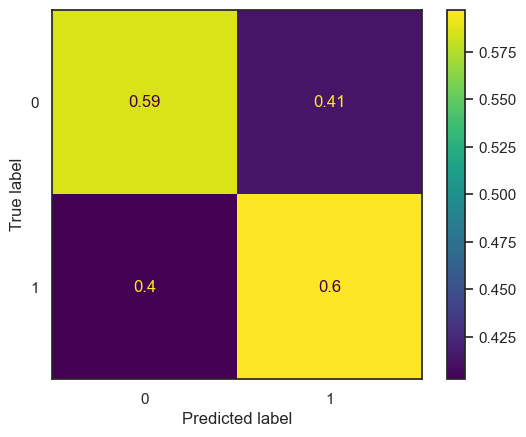

In [7]:
# Print confusion matrix on testing data
y_pred = mdl.predict(X_test)

print(metrics.roc_auc_score(y_test, y_pred))

confusion_matrix = metrics.confusion_matrix(y_test, y_pred, normalize='true')
conf_display = metrics.ConfusionMatrixDisplay(confusion_matrix)
conf_display.plot()
plt.show()

In [14]:
# Perform 2-sample test for proportions to see if logistic regression predicts wins better than the baseline Elo rating

correct = [np.sum(np.where(np.exp(df['logodds']) > 1, 1, 0) == df['won']), np.sum(mdl.predict(df.drop(labels=['won'], axis=1)) == df['won'])]
total = [len(df.index), len(df.index)]
test_stat, pval = proportions_ztest(count=correct, nobs=total, alternative='smaller')
print(f'z = {test_stat}, pval = {pval}')

z = -3.0301115141537767, pval = 0.0012223172956404022


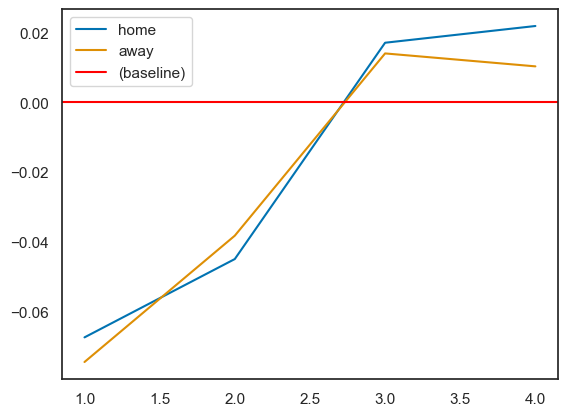

       home      away
1 -0.067368 -0.074430
2 -0.044910 -0.038209
3  0.017111  0.014047
4  0.021908  0.010338


In [10]:
# Visualize how home/away games impact performance

vis_df = pd.DataFrame(data=np.nan, index=range(1, 5), columns=['home', 'away'])
for delay in vis_df.index:
    for var in vis_df.columns:
        var_name = var + str(delay)
        vis_df.loc[delay, var] = np.exp(coef_sr.loc[var_name]) - 1
sns.lineplot(vis_df, dashes=False)
plt.axhline(0, label='(baseline)', color='red')
plt.legend()
plt.show()

print(vis_df)

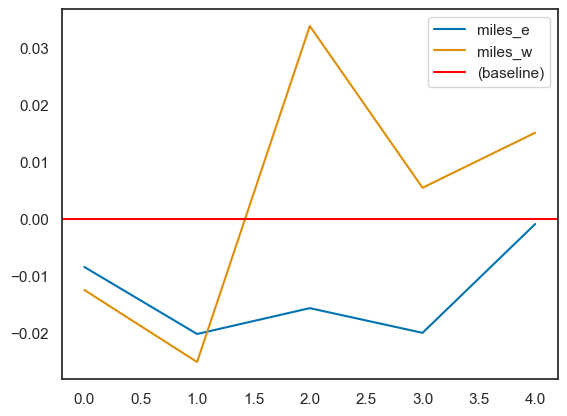

    miles_e   miles_w
0 -0.008487 -0.012515
1 -0.020227 -0.025133
2 -0.015698  0.033720
3 -0.020025  0.005388
4 -0.000951  0.015036


In [11]:
# Visualize how miles traveled games impact performance

vis_df = pd.DataFrame(data=np.nan, index=range(5), columns=['miles_e', 'miles_w'])
for delay in vis_df.index:
    for var in vis_df.columns:
        var_name = var + str(delay)
        vis_df.loc[delay, var] = np.exp(1000 * coef_sr.loc[var_name]) - 1
sns.lineplot(vis_df, dashes=False)
plt.axhline(0, label='(baseline)', color='red')
plt.legend()
plt.show()

print(vis_df)

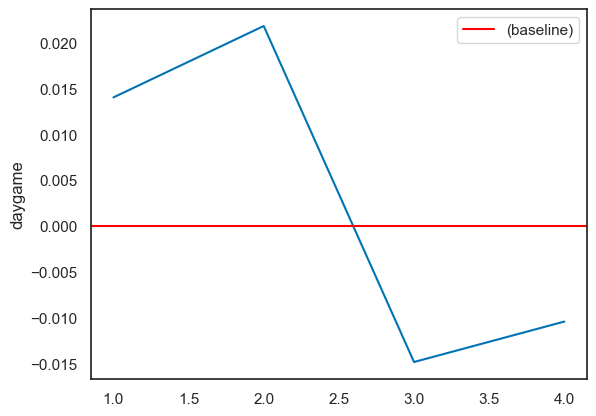

    daygame
1  0.014008
2  0.021788
3 -0.014816
4 -0.010411


In [12]:
# Visualize how day/night games impact performance

vis_df = pd.DataFrame(data=np.nan, index=range(1, 5), columns=['daygame'])
for delay in vis_df.index:
    for var in vis_df.columns:
        var_name = var + str(delay)
        vis_df.loc[delay, var] = np.exp(coef_sr.loc[var_name]) - 1
sns.lineplot(vis_df['daygame'], dashes=False)
plt.axhline(0, label='(baseline)', color='red')
plt.legend()
plt.show()

print(vis_df)